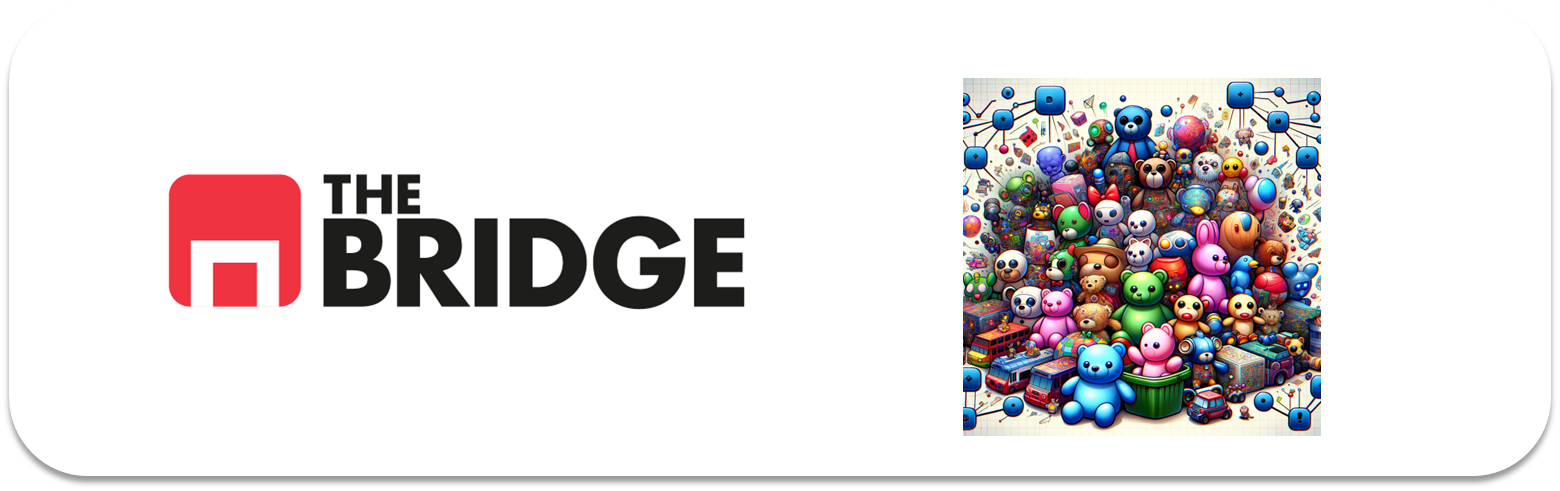

## PRACTICA OBLIGATORIA: **K-Means Clustering**

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado sobre imágenes para practicar con el algoritmo k-means. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## **#1**

Vamos a trabajar con un dataset también entre los "clásicos" (aunque a veces menos conocido) que es el de rostros Olivetti. Este dataset contiene 400 imágenes en escala de grises de 64 × 64 píxeles de rostros.   


Como en otros datasets de imágenes, estás están "aplanadas" de forma que cada pixel es una feature y por cada imagen hay $64\times 64 = 4096$ features.  

Se fotografiaron 40 personas diferentes (10 veces cada una) y esas fotografías se recogen en el dataset.  

La tarea habitual es entrenar un modelo que pueda predecir qué persona está representada en cada imagen, pero nosotros lo vamos a hacer de forma no supervisada. 



### #1.1


Carga el conjunto de datos usando la función `sklearn.datasets.fetch_olivetti_faces()`. Recuerda que se carga un "diccionario". Muestra su descripción acudiendo a la clave "DESCR".

In [2]:
olivetti = fetch_olivetti_faces()
print(olivetti['DESCR'])

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\elnom\scikit_learn_data
.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position
    (with tolerance for s

### #1.2 

Aunque no lo vas a usar hasta el final de la práctica, muestra el target. Luego cargalo todo en un mismo dataframe (tendrás que añadir el target) y obtén otro dataset con todas las imagenes reordenadas aleatoriamente (emplea por ejemplo el método `sample` del dataframe o el método que tú quieras)

In [3]:
print("\nTarget:")
print(olivetti['target'])

df = pd.DataFrame(olivetti['data'])
df['target'] = olivetti['target']

df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(f"\nDataframe shape: {df_shuffled.shape}")


Target:
[ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  7  7
  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9
  9  9  9  9 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 14 14 14 14
 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16
 16 16 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 19 19
 19 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20 20 20 21 21 21 21 21 21
 21 21 21 21 22 22 22 22 22 22 22 22 22 22 23 23 23 23 23 23 23 23 23 23
 24 24 24 24 24 24 24 24 24 24 25 25 25 25 25 25 25 25 25 25 26 26 26 26
 26 26 26 26 26 26 27 27 27 27 27 27 27 27 27 27 28 28 28 28 28 28 28 28
 28 28 29 29 29 29 29 29 29 29 29 29 30 30 30 30 30 30 30 30 30 30 31 31
 31 31 31 31 31 31 31 31 32 32 32 32 32 32

### #1.3

Vamos a dividir en train y test, pero OJO RECUERDA QUE EN LOS PROBLEMAS NO SUPERVISADOS NO HAY SPLIT (porque no hay target), aquí lo hacemos para poder comparar posteriormente el clustering con la clasificación (ya que es uan práctica formativa).

Por tanto, divídelo en un conjunto de entrenamiento, un conjunto de validación y un conjunto de pruebas (80-10-10). Dado que el conjunto de datos es bastante pequeño, emplea un muestreo estratificado para asegurarse de que haya el mismo número de imágenes por persona en cada conjunto (estratificando por la columna que contenga el target)

NOTA: No hemos hecho hasta ahora la separación en tres sets, investiga por tu cuenta o bien haz primero un split 90-10 y luego otro split 89-11 sobre el de 80 (para que de los números aproximados), por ejemplo.

In [4]:
X_temp, X_test_full, y_temp, y_test_full = train_test_split(
    df_shuffled.drop('target', axis=1),
    df_shuffled['target'],
    test_size=0.10,
    stratify=df_shuffled['target'],
    random_state=42
)

X_train_full, X_valid_full, y_train_full, y_valid_full = train_test_split(
    X_temp,
    y_temp,
    test_size=0.111,
    stratify=y_temp,
    random_state=42
)

print(f"\nTrain: {len(X_train_full)}, Validation: {len(X_valid_full)}, Test: {len(X_test_full)}")


Train: 320, Validation: 40, Test: 40


### #1.4

Crea los pares X,y para train, validation y test.

In [5]:
X_train = X_train_full.values
y_train = y_train_full.values
X_valid = X_valid_full.values
y_valid = y_valid_full.values
X_test = X_test_full.values
y_test = y_test_full.values

Utiliza la siguiente función para visualizar alguna de las caras (observa que tienes que dar la X y la y, usa iloc en ambos datasets)

In [6]:
def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

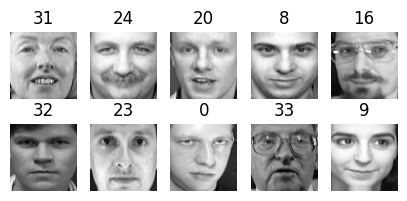

In [7]:
plot_faces(X_train[:10], y_train[:10])

### #1.5

Para acelerar las cosas, reduciremos la dimensionalidad de los datos utilizando PCA (técnica que veremos en el siguiente sprint). Modifica la siguiente celda de forma que las X se correspondan con las que has utilizado en el ejercicio anterior.

In [8]:
from sklearn.decomposition import PCA
pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)
print(f"\nComponentes PCA: {pca.n_components_}")


Componentes PCA: 221


### 1.6

Aquí viene la parte del león. A continuación, agrupa las imágenes utilizando K-Means sobre el dataset de train reducido en el ejercicio anterior. Emplea el método del máximo de score de silueta para obtener el mejor k, probando con K de 5 en 5 hasta 150. ¿Cuál es el k que proporciona el mejor score de silueta? NOTA: Emplea todas las features (no hace falta seleccionar, y ya están escaladas entre 0 y 1)

K=5, Silhouette Score=0.1088
K=10, Silhouette Score=0.1040
K=15, Silhouette Score=0.1020
K=20, Silhouette Score=0.1082
K=25, Silhouette Score=0.1183
K=30, Silhouette Score=0.1243
K=35, Silhouette Score=0.1534
K=40, Silhouette Score=0.1497
K=45, Silhouette Score=0.1570
K=50, Silhouette Score=0.1714
K=55, Silhouette Score=0.1770
K=60, Silhouette Score=0.1783
K=65, Silhouette Score=0.1889
K=70, Silhouette Score=0.1882
K=75, Silhouette Score=0.1936
K=80, Silhouette Score=0.1955
K=85, Silhouette Score=0.1989
K=90, Silhouette Score=0.1976
K=95, Silhouette Score=0.1985
K=100, Silhouette Score=0.1957
K=105, Silhouette Score=0.2007
K=110, Silhouette Score=0.1989
K=115, Silhouette Score=0.1893
K=120, Silhouette Score=0.1925
K=125, Silhouette Score=0.1968
K=130, Silhouette Score=0.2020
K=135, Silhouette Score=0.1970
K=140, Silhouette Score=0.1983
K=145, Silhouette Score=0.1966
K=150, Silhouette Score=0.1971

Mejor K (Silhouette): 130 con score 0.2020


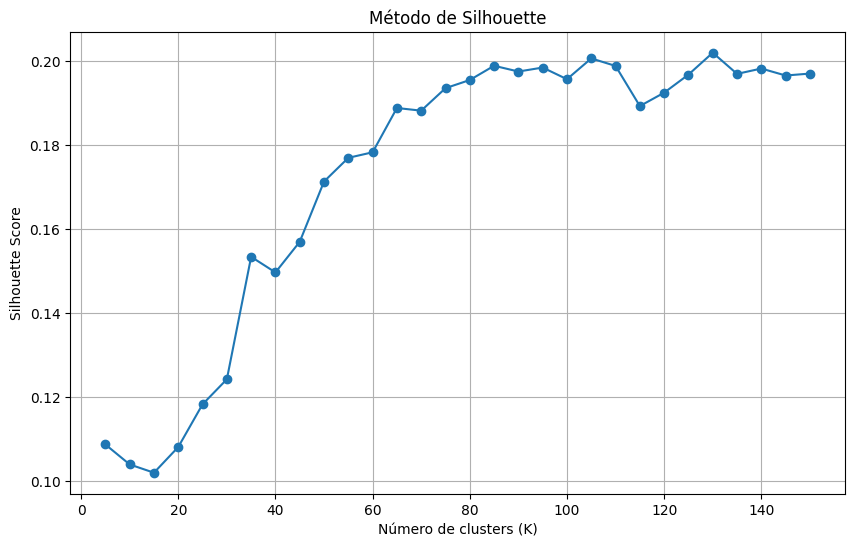

In [9]:
silhouette_scores = []
k_values = range(5, 151, 5)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_train_pca)
    score = silhouette_score(X_train_pca, labels)
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score={score:.4f}")

best_k_silhouette = k_values[np.argmax(silhouette_scores)]
print(f"\nMejor K (Silhouette): {best_k_silhouette} con score {max(silhouette_scores):.4f}")

plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Método de Silhouette')
plt.grid(True)
plt.show()

### #1.7

Repite el ejercio anterior empleando ahora el método del codo de Inercia. ¿Sale algo más concluyente o que refuerce el anterior resultado?

K=5, Inercia=17074.91
K=10, Inercia=14760.67
K=15, Inercia=13501.86
K=20, Inercia=12438.45
K=25, Inercia=11331.73
K=30, Inercia=10486.67
K=35, Inercia=9716.96
K=40, Inercia=9142.74
K=45, Inercia=8589.32
K=50, Inercia=8013.91
K=55, Inercia=7575.40
K=60, Inercia=7113.36
K=65, Inercia=6737.89
K=70, Inercia=6412.48
K=75, Inercia=6052.83
K=80, Inercia=5784.68
K=85, Inercia=5451.21
K=90, Inercia=5212.12
K=95, Inercia=4988.57
K=100, Inercia=4738.54
K=105, Inercia=4512.06
K=110, Inercia=4260.26
K=115, Inercia=4073.12
K=120, Inercia=3869.55
K=125, Inercia=3668.69
K=130, Inercia=3431.16
K=135, Inercia=3295.28
K=140, Inercia=3095.32
K=145, Inercia=2931.05
K=150, Inercia=2769.72


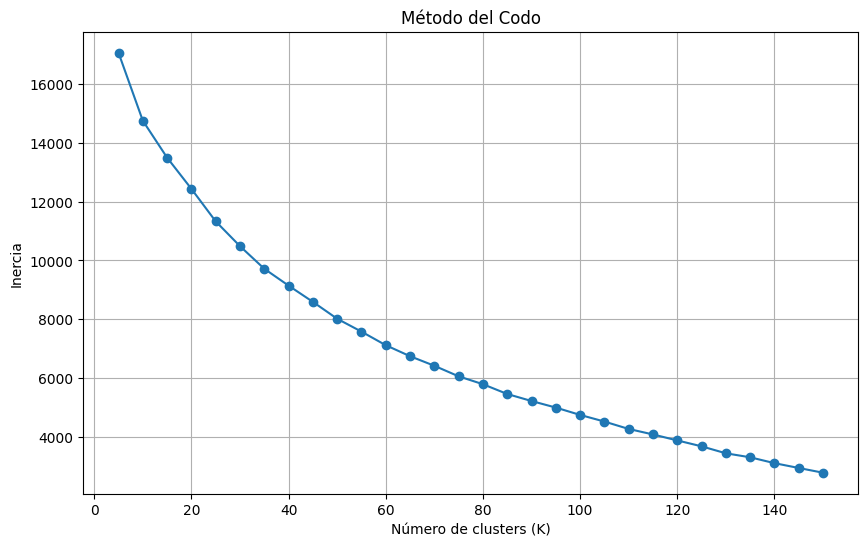

In [10]:
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_pca)
    inertias.append(kmeans.inertia_)
    print(f"K={k}, Inercia={kmeans.inertia_:.2f}")

plt.figure(figsize=(10, 6))
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.grid(True)
plt.show()

### #1.8

Quédate con el k obtenido con el método del score de silueta y asigna el modelo con ese k a una variable `best_model`

In [11]:
best_model = KMeans(n_clusters=best_k_silhouette, random_state=42, n_init=10)
best_model.fit(X_train_pca)
print(f"\nModelo entrenado con K={best_k_silhouette}")


Modelo entrenado con K=130


### #1.9

Haz una valoración del método de clustering para el K elegido. Para ello crea un programa que recorra la lista de etiquetas dadas por "best_model" y que, haciendo uso de la función que ya te hemos proporcionado, pinte las caras asignadas a los 10 primeros clústeres. Ojo tendrás que hacer una pequeña adaptación porque las features de entrenamiento no son las features reales (son una "transformación" de estas) y si pasas el X de entrenamiento no verás nada. ¿Ves caras similares?


Cluster 0: 2 imágenes


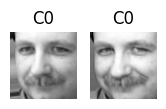


Cluster 1: 4 imágenes


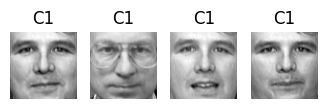


Cluster 2: 3 imágenes


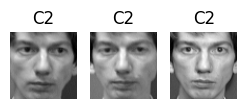


Cluster 3: 3 imágenes


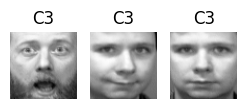


Cluster 4: 7 imágenes


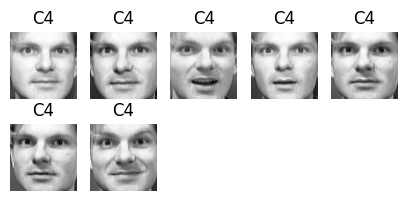


Cluster 5: 3 imágenes


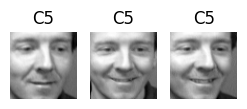


Cluster 6: 3 imágenes


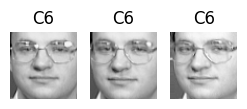


Cluster 7: 2 imágenes


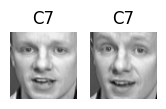


Cluster 8: 3 imágenes


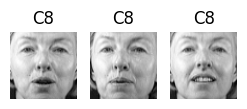


Cluster 9: 4 imágenes


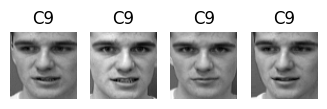

In [12]:
labels_train = best_model.labels_

for cluster_id in range(min(10, best_k_silhouette)):
    indices = np.where(labels_train == cluster_id)[0]
    print(f"\nCluster {cluster_id}: {len(indices)} imágenes")
    
    n_show = min(10, len(indices))
    if n_show > 0:
        plot_faces(X_train[indices[:n_show]], 
                  [f"C{cluster_id}" for _ in range(n_show)])

## **#2**


### #2.1


Continuando con el conjunto de datos de caras Olivetti, entrena un clasificador para predecir qué persona está representada en cada imagen, y evalúalo en el conjunto de validación. Utiliza un RandomForest con 150 submodelos o estimadores (y el resto de hiperparámetros déjalos a su valor por defecto)

In [13]:
rf_original = RandomForestClassifier(n_estimators=150, random_state=42)
rf_original.fit(X_train_pca, y_train)
y_pred_valid = rf_original.predict(X_valid_pca)
accuracy_original = accuracy_score(y_valid, y_pred_valid)
print(f"\nAccuracy RandomForest (PCA): {accuracy_original:.4f}")


Accuracy RandomForest (PCA): 0.9750


### #2.2

Utiliza K-Means como una herramienta de reducción de dimensionalidad y entrena un clasificador en el conjunto reducido. Para ello emplea el método transform de manera que ahora las features de entrada sean las distancias de cada punto a los centroides del modelo "best_model" de la parte anterior. Por ejemplo:
```python
X_train_reduced = best_model.transform(X_train_pca) 
```


Ojo lo tienes que aplicar a todos los datasets. Luego vuelve a entrenar un RandomForest sobre este dataset y evalualo contra el dataset de validacion.

In [14]:
X_train_reduced = best_model.transform(X_train_pca)
X_valid_reduced = best_model.transform(X_valid_pca)
X_test_reduced = best_model.transform(X_test_pca)

rf_reduced = RandomForestClassifier(n_estimators=150, random_state=42)
rf_reduced.fit(X_train_reduced, y_train)
y_pred_valid_reduced = rf_reduced.predict(X_valid_reduced)
accuracy_reduced = accuracy_score(y_valid, y_pred_valid_reduced)
print(f"Accuracy RandomForest (K-Means reduced): {accuracy_reduced:.4f}")

print(f"\nComparación:")
print(f"PCA ({pca.n_components_} features): {accuracy_original:.4f}")
print(f"K-Means ({best_k_silhouette} features): {accuracy_reduced:.4f}")

Accuracy RandomForest (K-Means reduced): 0.8750

Comparación:
PCA (221 features): 0.9750
K-Means (130 features): 0.8750
